In [45]:
import matplotlib
from delaunay_triangulations import Player, get_points_of_defenders, returner, get_lines_from_delaunay, \
    get_arrival_times, get_defensive_locations
# matplotlib.use("TkAgg")
import matplotlib.patches as patches
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay, ConvexHull, convex_hull_plot_2d
from helpers import get_play_description_from_number, inputpath, playpath
import time
from matplotlib import animation
from IPython.display import HTML
import os
import ipywidgets as widgets
from IPython.display import display,clear_output
from ipywidgets import Output, Button
import functools

plt.rcParams['figure.figsize'] = [18, 10]



def drawPitch(width, height, color="black"):
    fig = plt.figure()
    ax = plt.axes(xlim=(-10, width + 30), ylim=(-15, height + 5))
    plt.axis('off')

    # Grass around pitch
    rect = patches.Rectangle((-10, -5), width + 40, height + 10, linewidth=1, facecolor='#ddede5', capstyle='round')
    ax.add_patch(rect)
    ###################

    # Pitch boundaries
    rect = plt.Rectangle((0, 0), width + 20, height, ec=color, fc="None", lw=2)
    ax.add_patch(rect)
    ###################
    # vertical lines - every 5 yards
    for i in range(21):
        plt.plot([10 + 5 * i, 10 + 5 * i], [0, height], c="black", lw=2)
    ###################

    # distance markers - every 10 yards
    for yards in range(10, width, 10):
        yards_text = yards if yards <= width / 2 else width - yards
        # top markers
        plt.text(10 + yards - 2, height - 7.5, yards_text, size=20, c="black")
        # botoom markers
        plt.text(10 + yards - 2, 7.5, yards_text, size=20, c="black", rotation=180)
    ###################
        # yards markers - every yard
        # bottom markers
        for x in range(20):
            for j in range(1, 5):
                plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [1, 3], color="black", lw=3)

        # top markers
        for x in range(20):
            for j in range(1, 5):
                plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [height - 1, height - 3], color="black", lw=3)

        # middle bottom markers
        y = (height - 18.5) / 2
        for x in range(20):
            for j in range(1, 5):
                plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [y, y + 2], color="black", lw=3)
    # middle top markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [height - y, height - y - 2], color="black", lw=3)
    ###################

    # draw home end zone
    plt.text(2.5, (height - 10) / 2, "HOME", size=40, c="w", weight="bold", rotation=90)
    rect = plt.Rectangle((0, 0), 10, height, ec=color, fc="#0064dc", lw=2)
    ax.add_patch(rect)

    # draw away end zone
    plt.text(112.5, (height - 10) / 2, "AWAY", size=40, c="w", weight="bold", rotation=-90)
    rect = plt.Rectangle((width + 10, 0), 10, height, ec=color, fc="#c80014", lw=2)
    ax.add_patch(rect)
    ###################

    # draw extra spot point
    # left
    y = (height - 3) / 2
    plt.plot([10 + 2, 10 + 2], [y, y + 3], c="black", lw=2)

    # right
    plt.plot([width + 10 - 2, width + 10 - 2], [y, y + 3], c="black", lw=2)
    ###################

    # draw goalpost
    goal_width = 6  # yards
    y = (height - goal_width) / 2
    # left
    plt.plot([0, 0], [y, y + goal_width], "-", c="y", lw=10, ms=20)
    # right
    plt.plot([width + 20, width + 20], [y, y + goal_width], "-", c="black", lw=10, ms=20)

    return fig, ax


def extract_one_game(game):
    home = {}
    away = {}
    balls = []

    players = game.sort_values(['frameId'], ascending=True).groupby('nflId')
    for id, dx in players:
        jerseyNumber = int(dx.jerseyNumber.iloc[0])
        if dx.team.iloc[0] == "home":
            home[jerseyNumber] = list(zip(dx.x.tolist(), dx.y.tolist()))
        elif dx.team.iloc[0] == "away":
            away[jerseyNumber] = list(zip(dx.x.tolist(), dx.y.tolist()))

    ball_df = game.sort_values(['frameId'], ascending=True)
    ball_df = ball_df[ball_df.team == "football"]
    balls = list(zip(ball_df.x.tolist(), ball_df.y.tolist()))
    return home, away, balls




def process_frames(csv, delaunay=False):

    receive_frame = csv[csv['event'] == 'punt_received']['frameId'].iloc[0]
    punt_returner = returner(csv, receive_frame)
    attacking_team = csv[csv['displayName'] == punt_returner]['team'].iloc[0]
    attackers = []
    defenders = []

    for player in np.unique(csv['displayName']):
        player_csv = csv[csv['displayName'] == player][receive_frame:]
        size = np.shape(player_csv)[0]
        #size = 10
        team = csv[csv['displayName'] == player]['team'].iloc[0]
        if team == attacking_team:
            attackers.append(Player(player, player_csv['x'], player_csv['y'], team, 0.6))
        elif team != "football":
            defenders.append(Player(player, player_csv['x'], player_csv['y'], team, 0.6))

    returner_pos = csv[csv['displayName'] == punt_returner][receive_frame:]
    returner_pos = list(zip(returner_pos.x.tolist(), returner_pos.y.tolist()))


    ball_df = csv.sort_values(['frameId'], ascending=True)
    ball_df = ball_df[ball_df.team == "football"][receive_frame:]
    balls = list(zip(ball_df.x.tolist(), ball_df.y.tolist()))

    #DO CALC BEFORE TO SPEED UP VISUALS
    points_def = []
    points_off = []
    lines = []
    times = []
    bound_points_x =[]
    bound_points_y = []
    outer_layer_x = []
    outer_layer_y = []

    start_time = time.time()
    # Get data before for smooth animation
    for frame in range(size):
        print("Processed frame", frame, "/",size,"||",round((frame/size)*100,3),"%")
        points_def.append(np.array(get_points_of_defenders(defenders, frame)))
        points_off.append(np.array(get_points_of_defenders(attackers, frame)))
        if delaunay:
            bounds = ConvexHull(points_def[frame]).vertices
            for element in bounds:
                bound_points_x.append(points_def[frame][element][0])
                bound_points_y.append(points_def[frame][element][1])

            outer_layer_x.append(bound_points_x)
            outer_layer_y.append(bound_points_y)
            bound_points_x = []
            bound_points_y = []

        tri = Delaunay(points_def[frame])
        lines.append(get_lines_from_delaunay(tri, defenders,frame))
        times.append(get_arrival_times(lines[frame], defenders, attackers,frame))
    end_time = time.time()
    print("Took",round(end_time-start_time,2),"s to process",size,"frames")
    return size, returner_pos, points_def, points_off, balls, lines, times, outer_layer_x, outer_layer_y


def animate_one_play(home, away, balls, return_line, lines,times):
    fig, ax = drawPitch(100, 53.3)
    

    team_left, = ax.plot([], [], 'o', markersize=12, markerfacecolor="r", markeredgewidth=1, markeredgecolor="white", zorder=7)
    team_right, = ax.plot([], [], 'o', markersize=12, markerfacecolor="b", markeredgewidth=1, markeredgecolor="white", zorder=7)
    ball, = ax.plot([], [], 'o', markersize=8, markerfacecolor="black", markeredgewidth=1, markeredgecolor="white", zorder=7)
    returner_line, = ax.plot([],[], "--", zorder=5, c="black")
    returner_path, = ax.plot([], [], "-", zorder=5, c="gray", linewidth=5)
    returner_pos, = ax.plot([], [], 'o', markersize=13, markerfacecolor="gray", markeredgewidth=1, markeredgecolor="white", zorder=9)

    p = ax.scatter(lines[0][:, 0], lines[0][:, 1], c=times[0], cmap="YlOrRd", marker="s", s=5, zorder=5)






    drawings = [team_left, team_right, ball, returner_line, returner_path, returner_pos, p]

    def init():
        team_left.set_data([], [])
        team_right.set_data([], [])
        ball.set_data([], [])
        returner_line.set_data([],[])
        returner_path.set_data([x[0] for x in return_line], [x[1] for x in return_line])
        returner_pos.set_data([],[])

        return drawings

    def draw_teams(i):
        X = []
        Y = []
        for x,y in home[i]:
            X.append(x)
            Y.append(y)
        team_left.set_data(X, Y)
        
        X = []
        Y = []
        for x,y in away[i]:
            X.append(x)
            Y.append(y)
        team_right.set_data(X, Y)
                
        returner_pos.set_data(return_line[i][0], return_line[i][1])

        

    def animate(i):
        draw_teams(i)
        
        x, y = balls[i]
        ball.set_data([x, y])
        x, y = return_line[i]
        returner_line.set_data([[x, x], [0,53.3]])
        X = []
        Y = []
        for x,y in lines[i]:
            X.append(x)
            Y.append(y)
        
        p.set_offsets(np.transpose([X,Y]))
        
        return drawings
    
    
    # !May take a while!
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(balls), interval=100, blit=False)

    return HTML(anim.to_html5_video())

In [43]:
plays = os.listdir(inputpath+"receiving_plays")
plays.sort()

In [44]:
anim_values = []
start = Button(description="Process Frames")
out = Output()
plays_widget = widgets.Dropdown(
    options=plays,
    value=plays[0],
    description='Play:',
    disabled=False,
)

def click_start(b):
    csv = pd.read_csv(inputpath+"receiving_plays/"+plays_widget.value)
    size,returner_pos,home,away,balls,lines,times,ox,oy = process_frames(csv, delaunay=True)
    anim_values.extend([returner_pos, home,away,balls,lines,times,ox,oy])
       

with out:
    out.clear_output()
    anim_values = []
    start.on_click(functools.partial(click_start ))


display(plays_widget, start)

Dropdown(description='Play:', options=('play1000-game2020122602.csv', 'play1000-game2020122705.csv', 'play1000…

Button(description='Process Frames', style=ButtonStyle())

Processed frame 0 / 96 || 0.0 %
Processed frame 1 / 96 || 1.042 %
Processed frame 2 / 96 || 2.083 %
Processed frame 3 / 96 || 3.125 %
Processed frame 4 / 96 || 4.167 %
Processed frame 5 / 96 || 5.208 %
Processed frame 6 / 96 || 6.25 %
Processed frame 7 / 96 || 7.292 %
Processed frame 8 / 96 || 8.333 %
Processed frame 9 / 96 || 9.375 %
Processed frame 10 / 96 || 10.417 %
Processed frame 11 / 96 || 11.458 %
Processed frame 12 / 96 || 12.5 %
Processed frame 13 / 96 || 13.542 %
Processed frame 14 / 96 || 14.583 %
Processed frame 15 / 96 || 15.625 %
Processed frame 16 / 96 || 16.667 %
Processed frame 17 / 96 || 17.708 %
Processed frame 18 / 96 || 18.75 %
Processed frame 19 / 96 || 19.792 %
Processed frame 20 / 96 || 20.833 %
Processed frame 21 / 96 || 21.875 %
Processed frame 22 / 96 || 22.917 %
Processed frame 23 / 96 || 23.958 %
Processed frame 24 / 96 || 25.0 %
Processed frame 25 / 96 || 26.042 %
Processed frame 26 / 96 || 27.083 %
Processed frame 27 / 96 || 28.125 %
Processed frame 28 /

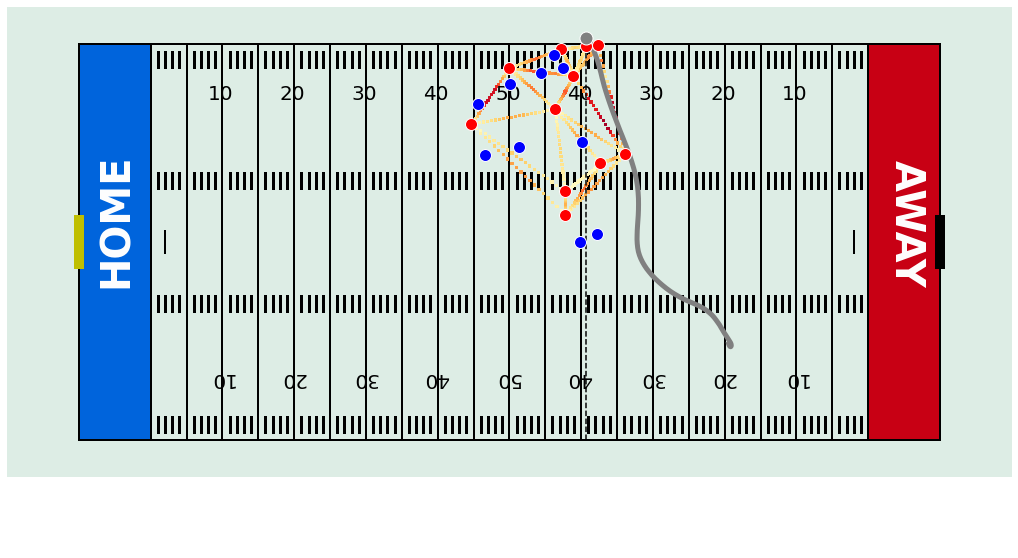

In [46]:
animate_one_play(anim_values[1],anim_values[2],anim_values[3],anim_values[0],anim_values[4],anim_values[5])